# Visualization

We will show:

1. **Saliency Maps**: Saliency maps are a quick way to tell which part of the image influenced the classification decision made by the network.
2. **Attention Maps**: We can perturb an input image so that it appears the same to humans, but will be misclassified by the pretrained network.
3. **Class Visualization**: We can synthesize an image to maximize the classification score of a particular class; this can give us some sense of what the network is looking for when it classifies images of that class.

In [13]:
import torch
import torchvision
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
from visualization.image_utils import SQUEEZENET_MEAN, SQUEEZENET_STD
from visualization.net_visualization_pytorch import preprocess, deprocess, rescale, blur_image
# Load saliency maps computation function
from visualization.net_visualization_pytorch import compute_saliency_maps
from vis_transconv import get_model_transconv

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Not using distributed mode
Namespace(aa='rand-m9-mstd0.5-inc1', batch_size=180, clip_grad=None, color_jitter=0.4, cooldown_epochs=10, cutmix=1.0, cutmix_minmax=None, data_path='/home/hawei/Dataset/ImageNet_ILSVRC2012_FULL/', data_set='IMNET', decay_epochs=30, decay_rate=0.1, device='cpu', dist_url='env://', distributed=False, drop=0.0, drop_block=None, drop_path=0.1, epochs=20, eval=False, evaluate_freq=1, finetune='', finetune_conv=True, finetune_vit=False, inat_category='name', input_size=224, log_tensorboard=False, lr=0.0005, lr_noise=None, lr_noise_pct=0.67, lr_noise_std=1.0, min_lr=1e-05, mixup=0.8, mixup_mode='batch', mixup_prob=1.0, mixup_switch_prob=0.5, model='Transconv_base_patch14', model_ema=True, model_ema_decay=0.99996, model_ema_force_cpu=False, momentum=0.9, num_workers=6, opt='adamw', opt_betas=None, opt_eps=1e-08, output_dir='/home/hawei/Output', patience_epochs=10, pin_mem=True, pretrained=True, recount=1, remode='pixel', repeated_aug=True, reprob=0.25, resplit=False

Failed to find state_dict_ema, starting from loaded model weights


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Pretrained Model

We will compare our result to resnet101.

In [2]:
# Download and load the pretrained resnet101 model.
model_resnet101 = torchvision.models.resnet101(pretrained=True)

# We don't want to train the model
for param in model_resnet101.parameters():
    param.requires_grad = False
    
# Proposed Model
model_transconv = get_model_transconv('eval', model='Transconv_small_patch16')

Not using distributed mode
Namespace(aa='rand-m9-mstd0.5-inc1', batch_size=180, clip_grad=None, color_jitter=0.4, cooldown_epochs=10, cutmix=1.0, cutmix_minmax=None, data_path='/home/hawei/Dataset/ImageNet_ILSVRC2012_FULL/', data_set='IMNET', decay_epochs=30, decay_rate=0.1, device='cuda', dist_url='env://', distributed=False, drop=0.0, drop_block=None, drop_path=0.1, epochs=20, eval=False, evaluate_freq=1, finetune='', finetune_conv=True, finetune_vit=False, inat_category='name', input_size=224, log_tensorboard=False, lr=0.0005, lr_noise=None, lr_noise_pct=0.67, lr_noise_std=1.0, min_lr=1e-05, mixup=0.8, mixup_mode='batch', mixup_prob=1.0, mixup_switch_prob=0.5, model='Transconv_small_patch16', model_ema=True, model_ema_decay=0.99996, model_ema_force_cpu=False, momentum=0.9, num_workers=6, opt='adamw', opt_betas=None, opt_eps=1e-08, output_dir='/home/hawei/Output', patience_epochs=10, pin_mem=True, pretrained=True, recount=1, remode='pixel', repeated_aug=True, reprob=0.25, resplit=Fal

Failed to find state_dict_ema, starting from loaded model weights


Evaluation result on ImageNet Test Set and Yes, we got 83.6% for small model and 86.5% for large model 

In [3]:
from engine import evaluate
from vis_transconv import get_dataset, get_data_loader

_, dataset_val = get_dataset()
data_loader_val = get_data_loader(dataset_val)

test_stats = evaluate(data_loader_val, model_transconv, 'cuda')

print(f"Accuracy of the network on the {len(dataset_val)} test images: {test_stats['acc1']:.1f}%")


Test:  [  0/261]  eta: 0:41:50  loss: 0.4780 (0.4780)  loss_0: 0.2652 (0.2652)  loss_1: 0.2127 (0.2127)  acc1: 92.7083 (92.7083)  acc1_head1: 91.1458 (91.1458)  acc1_head2: 92.1875 (92.1875)  time: 9.6190  data: 2.8982  max mem: 3772
Test:  [ 10/261]  eta: 0:18:45  loss: 0.4780 (0.5663)  loss_0: 0.2730 (0.3157)  loss_1: 0.2127 (0.2506)  acc1: 92.7083 (89.4886)  acc1_head1: 91.1458 (89.4886)  acc1_head2: 92.1875 (89.1572)  time: 4.4823  data: 0.2637  max mem: 3772
Test:  [ 20/261]  eta: 0:17:02  loss: 0.7393 (0.6969)  loss_0: 0.3952 (0.3796)  loss_1: 0.3441 (0.3173)  acc1: 84.8958 (85.4415)  acc1_head1: 84.3750 (85.2679)  acc1_head2: 84.8958 (85.4415)  time: 3.9724  data: 0.0002  max mem: 3772
Test:  [ 30/261]  eta: 0:16:00  loss: 0.6138 (0.6299)  loss_0: 0.3369 (0.3463)  loss_1: 0.2769 (0.2836)  acc1: 90.1042 (87.8192)  acc1_head1: 88.0208 (87.5840)  acc1_head2: 90.6250 (87.8360)  time: 3.9765  data: 0.0002  max mem: 3772
Test:  [ 40/261]  eta: 0:15:09  loss: 0.4498 (0.5968)  loss_0: 0

In [4]:
test_stats

{'loss': 0.8005766251991535,
 'loss_0': 0.43422945745831704,
 'loss_1': 0.36634716754101243,
 'acc1': 83.64200258789063,
 'acc1_head1': 82.936002265625,
 'acc1_head2': 83.69400262207031}

Now, let's test our large model, too large so local gpu does not hold.

In [17]:
large_model_transconv = get_model_transconv(mode='eval', model='Transconv_base_patch14', device='cpu')

test_stats_large = evaluate(data_loader_val, model_transconv, 'cpu')

print(f"Accuracy of the network on the {len(dataset_val)} test images: {test_stats['acc1']:.1f}%")

Not using distributed mode
Namespace(aa='rand-m9-mstd0.5-inc1', batch_size=180, clip_grad=None, color_jitter=0.4, cooldown_epochs=10, cutmix=1.0, cutmix_minmax=None, data_path='/home/hawei/Dataset/ImageNet_ILSVRC2012_FULL/', data_set='IMNET', decay_epochs=30, decay_rate=0.1, device='cpu', dist_url='env://', distributed=False, drop=0.0, drop_block=None, drop_path=0.1, epochs=20, eval=False, evaluate_freq=1, finetune='', finetune_conv=True, finetune_vit=False, inat_category='name', input_size=224, log_tensorboard=False, lr=0.0005, lr_noise=None, lr_noise_pct=0.67, lr_noise_std=1.0, min_lr=1e-05, mixup=0.8, mixup_mode='batch', mixup_prob=1.0, mixup_switch_prob=0.5, model='Transconv_base_patch14', model_ema=True, model_ema_decay=0.99996, model_ema_force_cpu=False, momentum=0.9, num_workers=6, opt='adamw', opt_betas=None, opt_eps=1e-08, output_dir='/home/hawei/Output', patience_epochs=10, pin_mem=True, pretrained=True, recount=1, remode='pixel', repeated_aug=True, reprob=0.25, resplit=False

Failed to find state_dict_ema, starting from loaded model weights


Test:  [  0/261]  eta: 0:37:04  loss: 0.4780 (0.4780)  loss_0: 0.2652 (0.2652)  loss_1: 0.2127 (0.2127)  acc1: 92.7083 (92.7083)  acc1_head1: 91.1458 (91.1458)  acc1_head2: 92.1875 (92.1875)  time: 8.5246  data: 4.2957  max mem: 6049
Test:  [ 10/261]  eta: 0:18:17  loss: 0.4780 (0.5663)  loss_0: 0.2730 (0.3157)  loss_1: 0.2127 (0.2506)  acc1: 92.7083 (89.4886)  acc1_head1: 91.1458 (89.4886)  acc1_head2: 92.1875 (89.1572)  time: 4.3732  data: 0.3909  max mem: 6049
Test:  [ 20/261]  eta: 0:16:48  loss: 0.7393 (0.6969)  loss_0: 0.3952 (0.3796)  loss_1: 0.3441 (0.3173)  acc1: 84.8958 (85.4415)  acc1_head1: 84.3750 (85.2679)  acc1_head2: 84.8958 (85.4415)  time: 3.9656  data: 0.0004  max mem: 6049
Test:  [ 30/261]  eta: 0:15:51  loss: 0.6138 (0.6299)  loss_0: 0.3369 (0.3463)  loss_1: 0.2769 (0.2836)  acc1: 90.1042 (87.8192)  acc1_head1: 88.0208 (87.5840)  acc1_head2: 90.6250 (87.8360)  time: 3.9771  data: 0.0004  max mem: 6049
Test:  [ 40/261]  eta: 0:15:02  loss: 0.4498 (0.5968)  loss_0: 0

In [18]:
test_stats_large

Not using distributed mode
Namespace(aa='rand-m9-mstd0.5-inc1', batch_size=180, clip_grad=None, color_jitter=0.4, cooldown_epochs=10, cutmix=1.0, cutmix_minmax=None, data_path='/home/hawei/Dataset/ImageNet_ILSVRC2012_FULL/', data_set='IMNET', decay_epochs=30, decay_rate=0.1, device='cpu', dist_url='env://', distributed=False, drop=0.0, drop_block=None, drop_path=0.1, epochs=20, eval=False, evaluate_freq=1, finetune='', finetune_conv=True, finetune_vit=False, inat_category='name', input_size=224, log_tensorboard=False, lr=0.0005, lr_noise=None, lr_noise_pct=0.67, lr_noise_std=1.0, min_lr=1e-05, mixup=0.8, mixup_mode='batch', mixup_prob=1.0, mixup_switch_prob=0.5, model='Transconv_base_patch14', model_ema=True, model_ema_decay=0.99996, model_ema_force_cpu=False, momentum=0.9, num_workers=6, opt='adamw', opt_betas=None, opt_eps=1e-08, output_dir='/home/hawei/Output', patience_epochs=10, pin_mem=True, pretrained=True, recount=1, remode='pixel', repeated_aug=True, reprob=0.25, resplit=False

Failed to find state_dict_ema, starting from loaded model weights
[autoreload of vis_transconv failed: Traceback (most recent call last):
  File "/home/hawei/.local/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/hawei/.local/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/usr/lib64/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/usr/lib64/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/hawei/robustvision/conformer/vis_transconv.py", line 87, in <module>
    test_stats_large = evaluate(data_loader_val, large_model_transco

NameError: name 'test_stats_large' is not defined

## Load some ImageNet images
We have provided a few example images from the validation set of the ImageNet ILSVRC 2012 Classification dataset. To download these images, descend into `cs231n/datasets/` and run `get_imagenet_val.sh`.

Since they come from the validation set, our pretrained model did not see these images during training.

Run the following cell to visualize some of these images, along with their ground-truth labels.

In [4]:
# get images from the validation set of the ImageNet ILSVRC 2012 Classification dataset
%cd ~/robustvision/conformer/visualization/datasets
!bash ../get_imagenet_val.sh
%cd ../..

/home/hawei/robustvision/conformer/visualization/datasets
--2022-06-01 00:43:12--  http://cs231n.stanford.edu/imagenet_val_25.npz
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3940548 (3.8M) [text/plain]
Saving to: ‘imagenet_val_25.npz.6’

100%[======================================>] 3,940,548   8.10MB/s   in 0.5s   

2022-06-01 00:43:13 (8.10 MB/s) - ‘imagenet_val_25.npz.6’ saved [3940548/3940548]

/home/hawei/robustvision/conformer


Not using distributed mode
Namespace(aa='rand-m9-mstd0.5-inc1', batch_size=180, clip_grad=None, color_jitter=0.4, cooldown_epochs=10, cutmix=1.0, cutmix_minmax=None, data_path='/home/hawei/Dataset/ImageNet_ILSVRC2012_FULL/', data_set='IMNET', decay_epochs=30, decay_rate=0.1, device='cuda', dist_url='env://', distributed=False, drop=0.0, drop_block=None, drop_path=0.1, epochs=20, eval=False, evaluate_freq=1, finetune='', finetune_conv=True, finetune_vit=False, inat_category='name', input_size=224, log_tensorboard=False, lr=0.0005, lr_noise=None, lr_noise_pct=0.67, lr_noise_std=1.0, min_lr=1e-05, mixup=0.8, mixup_mode='batch', mixup_prob=1.0, mixup_switch_prob=0.5, model='Transconv_base_patch14', model_ema=True, model_ema_decay=0.99996, model_ema_force_cpu=False, momentum=0.9, num_workers=6, opt='adamw', opt_betas=None, opt_eps=1e-08, output_dir='/home/hawei/Output', patience_epochs=10, pin_mem=True, pretrained=True, recount=1, remode='pixel', repeated_aug=True, reprob=0.25, resplit=Fals

[autoreload of vis_transconv failed: Traceback (most recent call last):
  File "/home/hawei/.local/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/hawei/.local/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/usr/lib64/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/usr/lib64/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/hawei/robustvision/conformer/vis_transconv.py", line 86, in <module>
    large_model_transconv = get_model_transconv(mode='eval', model='Transconv_base_patch14', device='cuda')
  File "/home/hawei/robust

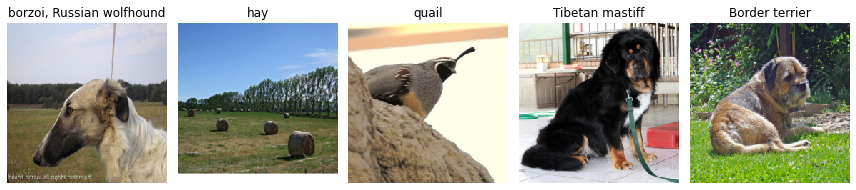

In [19]:
from visualization.data_utils import load_imagenet_val
from vis_transconv import get_dataset
dataset_train, dataset_val = get_dataset()
X, y, class_names = load_imagenet_val(num=4)
test_images = [Image.fromarray(x) for x in X]

# add one more imagge
def pil_loader(path: str) -> Image.Image:
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

path = '/home/hawei/Dataset/ImageNet_ILSVRC2012/train/n02090622/n02090622_1914.JPEG'
test_image = pil_loader(path)
test_image = test_image.resize((224,224))
test_images = [test_image] + test_images
x = np.asarray(test_image)
X = np.concatenate([x[None, :, :, :], X], axis=0)
y = np.insert(y, 0, dataset_train.class_to_idx['n02090622'])

plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X[i])
    plt.title(class_names[y[i]])
    plt.axis('off')
plt.gcf().tight_layout()

# Saliency Maps
Using this pretrained model, we will compute class saliency maps ours vs resnet101

Not using distributed mode
Namespace(aa='rand-m9-mstd0.5-inc1', batch_size=180, clip_grad=None, color_jitter=0.4, cooldown_epochs=10, cutmix=1.0, cutmix_minmax=None, data_path='/home/hawei/Dataset/ImageNet_ILSVRC2012_FULL/', data_set='IMNET', decay_epochs=30, decay_rate=0.1, device='cuda', dist_url='env://', distributed=False, drop=0.0, drop_block=None, drop_path=0.1, epochs=20, eval=False, evaluate_freq=1, finetune='', finetune_conv=True, finetune_vit=False, inat_category='name', input_size=224, log_tensorboard=False, lr=0.0005, lr_noise=None, lr_noise_pct=0.67, lr_noise_std=1.0, min_lr=1e-05, mixup=0.8, mixup_mode='batch', mixup_prob=1.0, mixup_switch_prob=0.5, model='Transconv_small_patch16', model_ema=True, model_ema_decay=0.99996, model_ema_force_cpu=False, momentum=0.9, num_workers=6, opt='adamw', opt_betas=None, opt_eps=1e-08, output_dir='/home/hawei/Output', patience_epochs=10, pin_mem=True, pretrained=True, recount=1, remode='pixel', repeated_aug=True, reprob=0.25, resplit=Fal

Failed to find state_dict_ema, starting from loaded model weights
[autoreload of vis_transconv failed: Traceback (most recent call last):
  File "/home/hawei/.local/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/hawei/.local/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/usr/lib64/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/usr/lib64/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/hawei/robustvision/conformer/vis_transconv.py", line 155, in <module>
    show_saliency_maps(model_transconv)
  File "/home/hawei/robustv

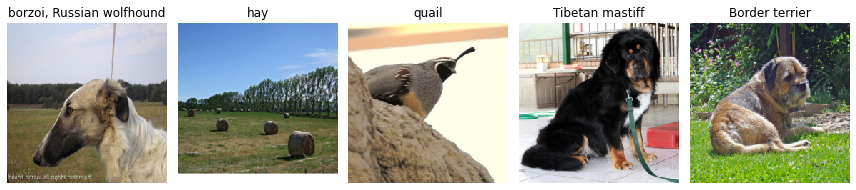

In [27]:

def show_saliency_maps(model, head=-1, device='cpu'):
    # Convert X and y from numpy arrays to Torch Tensors
    X_tensor = torch.cat([preprocess(test_image) for test_image in test_images], dim=0).to(device)
    y_tensor = torch.LongTensor(y).to(device)

    # Compute saliency maps for images in X
    saliency = compute_saliency_maps(X_tensor, y_tensor, model, head)

    # Convert the saliency map from Torch Tensor to numpy array and show images
    # and saliency maps together.
    saliency = saliency.numpy()
    N = X.shape[0]
    for i in range(N):
        plt.subplot(2, N, i + 1)
        plt.imshow(X[i])
        plt.axis('off')
        plt.title(class_names[y[i]])
        plt.subplot(2, N, N + i + 1)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(12, 5)
    plt.show()

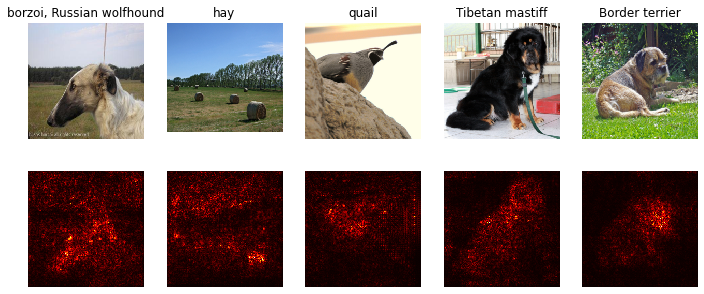

In [28]:
# show saliency map for model_resnet101
show_saliency_maps(model_resnet101, device='cpu')

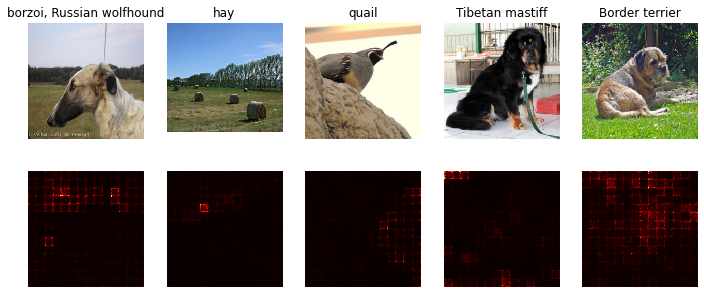

In [31]:
# saliency map for both conv and transfomer heads, -1 means both fused together
model_transconv.to(device='cpu')
show_saliency_maps(model_transconv, head=-1, device='cpu')

Let's do some ablation study, first remove the transformer tower and show the saliency map for conv tower

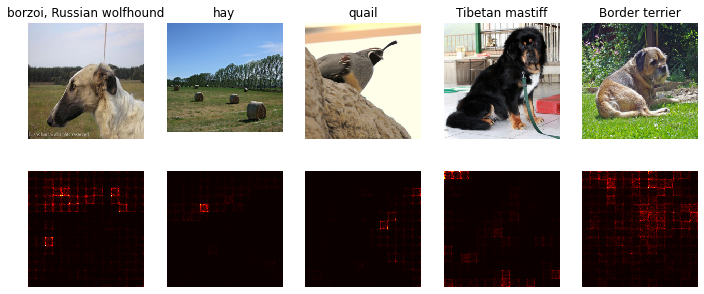

In [32]:
# saliency map for conv head
show_saliency_maps(model_transconv, head=0)

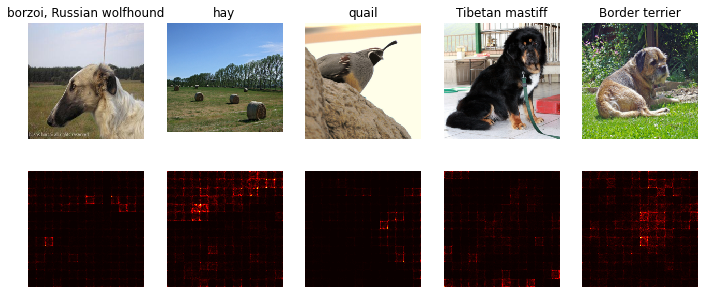

In [33]:
# saliency map for transformer head
show_saliency_maps(model_transconv, head=1)

# Fooling Images
We can also use image gradients to generate "fooling images" as discussed in [3]. Given an image and a target class, we can perform gradient **ascent** over the image to maximize the target class, stopping when the network classifies the image as the target class. Implement the following function to generate fooling images.

In [143]:
from visualization.net_visualization_pytorch import make_fooling_image
idx = 0
target_y = 6

X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
X_fooling = make_fooling_image(X_tensor[idx:idx+1], target_y, model_transconv)

scores = model_transconv(X_fooling)
head = -1
if isinstance(scores, list):
    scores = scores[head] if head != -1 else scores[0] + scores[1]
assert target_y == scores.data.max(1)[1][0].item(), 'The model is not fooled!'

<class 'int'> <class 'int'>


After generating a fooling image, run the following cell to visualize the original image, the fooling image, as well as the difference between them.

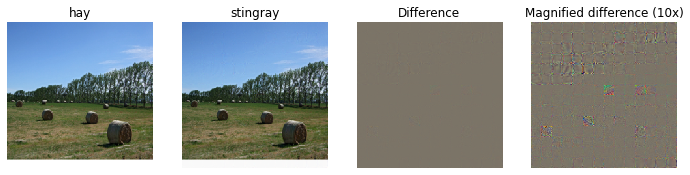

In [146]:
X_fooling_np = deprocess(X_fooling.clone())
X_fooling_np = np.asarray(X_fooling_np).astype(np.uint8)

plt.subplot(1, 4, 1)
plt.imshow(X[idx])
plt.title(class_names[y[idx]])
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(X_fooling_np)
plt.title(class_names[target_y])
plt.axis('off')

plt.subplot(1, 4, 3)
X_pre = preprocess(Image.fromarray(X[idx]))
diff = np.asarray(deprocess(X_fooling - X_pre, should_rescale=False))
plt.imshow(diff)
plt.title('Difference')
plt.axis('off')

plt.subplot(1, 4, 4)
diff = np.asarray(deprocess(10 * (X_fooling - X_pre), should_rescale=False))
plt.imshow(diff)
plt.title('Magnified difference (10x)')
plt.axis('off')

plt.gcf().set_size_inches(12, 5)
plt.show()

# Class visualization
By starting with a random noise image and performing gradient ascent on a target class, we can generate an image that the network will recognize as the target class.

In [147]:
from visualization.net_visualization_pytorch import class_visualization_update_step, jitter, blur_image
def create_class_visualization(target_y, model, dtype, **kwargs):
    """
    Generate an image to maximize the score of target_y under a pretrained model.

    Inputs:
    - target_y: Integer in the range [0, 1000) giving the index of the class
    - model: A pretrained CNN that will be used to generate the image
    - dtype: Torch datatype to use for computations

    Keyword arguments:
    - l2_reg: Strength of L2 regularization on the image
    - learning_rate: How big of a step to take
    - num_iterations: How many iterations to use
    - blur_every: How often to blur the image as an implicit regularizer
    - max_jitter: How much to jitter the image as an implicit regularizer
    - show_every: How often to show the intermediate result
    """
    model.type(dtype)
    l2_reg = kwargs.pop('l2_reg', 1e-3)
    learning_rate = kwargs.pop('learning_rate', 25)
    num_iterations = kwargs.pop('num_iterations', 100)
    blur_every = kwargs.pop('blur_every', 10)
    max_jitter = kwargs.pop('max_jitter', 16)
    show_every = kwargs.pop('show_every', 25)

    # Randomly initialize the image as a PyTorch Tensor, and make it requires gradient.
    img = torch.randn(1, 3, 224, 224).mul_(1.0).type(dtype).requires_grad_()

    for t in range(num_iterations):
        # Randomly jitter the image a bit; this gives slightly nicer results
        ox, oy = random.randint(0, max_jitter), random.randint(0, max_jitter)
        img.data.copy_(jitter(img.data, ox, oy))
        class_visualization_update_step(img, model, target_y, l2_reg, learning_rate)
        # Undo the random jitter
        img.data.copy_(jitter(img.data, -ox, -oy))

        # As regularizer, clamp and periodically blur the image
        for c in range(3):
            lo = float(-SQUEEZENET_MEAN[c] / SQUEEZENET_STD[c])
            hi = float((1.0 - SQUEEZENET_MEAN[c]) / SQUEEZENET_STD[c])
            img.data[:, c].clamp_(min=lo, max=hi)
        if t % blur_every == 0:
            blur_image(img.data, sigma=0.5)

        # Periodically show the image
        if t == 0 or (t + 1) % show_every == 0 or t == num_iterations - 1:
            plt.imshow(deprocess(img.data.clone().cpu()))
            class_name = class_names[target_y]
            plt.title('%s\nIteration %d / %d' % (class_name, t + 1, num_iterations))
            plt.gcf().set_size_inches(4, 4)
            plt.axis('off')
            plt.show()

    return deprocess(img.data.cpu())

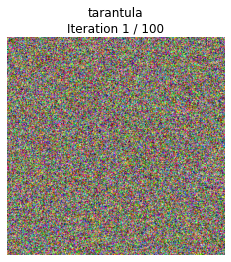

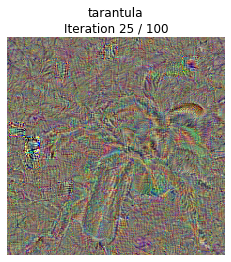

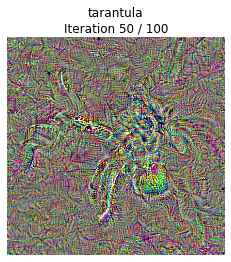

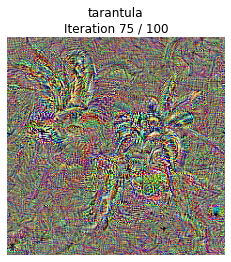

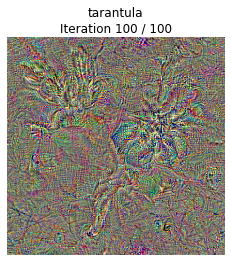

In [149]:
dtype = torch.FloatTensor
# dtype = torch.cuda.FloatTensor # Uncomment this to use GPU
model_transconv.type(dtype)

target_y = 76 # Tarantula
# target_y = 78 # Tick
# target_y = 187 # Yorkshire Terrier
# target_y = 683 # Oboe
# target_y = 366 # Gorilla
# target_y = 604 # Hourglass
out = create_class_visualization(target_y, model_transconv, dtype)

Try out your class visualization on other classes! You should also feel free to play with various hyperparameters to try and improve the quality of the generated image, but this is not required.

Yorkshire terrier


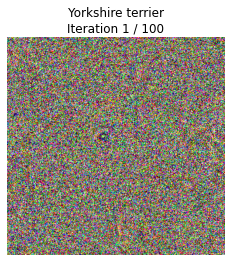

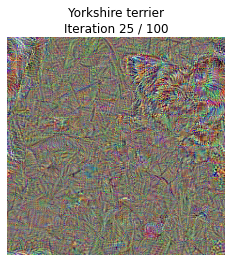

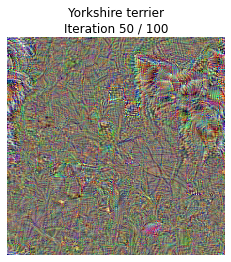

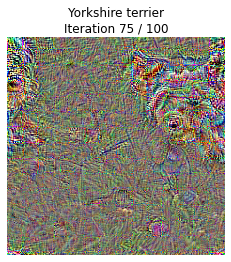

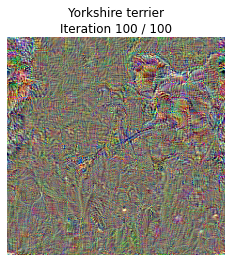

In [150]:
#target_y = np.random.randint(1000)
# target_y = 78 # Tick
target_y = 187 # Yorkshire Terrier
# target_y = 683 # Oboe
# target_y = 366 # Gorilla
# target_y = 604 # Hourglass
# target_y = np.random.randint(1000)
print(class_names[target_y])
X = create_class_visualization(target_y, model_transconv, dtype)#, l2_reg=5e-2, num_iterations=500, show_every=100)